In [1]:
import sys
import time
sys.path.append('../python')
from plot_info import *
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D
import keras

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
import os.path
from itertools import product

input_size=40

downscale = 8
train_size=downscale*downscale*128
validation_size=200
data_path='../../scratch/kh_1.nc'
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']
[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5668496321796273429
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 599982080
locality {
  bus_id: 1
}
incarnation: 8934547216377541708
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:02:00.0"
]


In [2]:

class AreaFunctional(object):
    def __init__(self, integrate_coordinate = [0.55,0.35], integrate_width=[0.25,0.25],variable='rho'):
        self.integrate_coordinate = integrate_coordinate
        self.integrate_width = integrate_width
        
        self.variable = variable
        self.first = 10
        
    def title(self):
        return 'integrated area: $[%f,%f]\\times [%f,%f]$'% (self.integrate_coordinate[0],
                                                            self.integrate_coordinate[1],
                                                            self.integrate_width[0],
                                                            self.integrate_width[1])
    def area(self, I):
        
        return 1*(I[1][0]-I[0][0])*(I[1][1]-I[0][1])
    def __call__(self, rho):
        N = rho.shape[0]
        
        integrate_area = [[int(N*self.integrate_coordinate[0]), int(N*self.integrate_coordinate[1])],
                          [int(N*self.integrate_coordinate[0]+N*self.integrate_width[0]), 
                           int(N*self.integrate_coordinate[1]+N*self.integrate_width[1])]]
        
        g = sum(rho[integrate_area[0][0]:integrate_area[1][0], integrate_area[0][1]:integrate_area[1][1]])/self.area(integrate_area)
        
      
        return g
    
    def plot(self, d):
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
        rect = matplotlib.patches.Rectangle((self.integrate_coordinate[0],self.integrate_coordinate[1]),
                                     self.integrate_width[0],
                                     self.integrate_width[1],
                                     linewidth=1,edgecolor='r',facecolor='none')
        
        axes = plt.gca()
        axes.add_patch(rect)
        plt.show()
        
        
class SinglePointFunctional(object):
    def __init__(self, coordinate = [0.55,0.35], variable='rho'):
        self.coordinate = coordinate
        
        self.variable = variable
        self.first = 10
        
    def title(self):
        return 'specific point  $(%f,%f)$'% (self.coordinate[0], self.coordinate[1])

    def __call__(self, rho):
        N = rho.shape[0]
        
        x = int(N*self.coordinate[0])
        y = int(N*self.coordinate[1])
        
        return rho[x,y]
    
    def plot(self, d):
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
        rect = matplotlib.patches.Rectangle((self.coordinate[0],self.coordinate[1]),
                                     0.05,
                                     0.05,
                                     linewidth=1,edgecolor='r',facecolor='r')
        
        axes = plt.gca()
        axes.add_patch(rect)
        plt.show()
    
    
class Identity(object):
    def __init__(self, variable='rho'):
        
        self.variable = variable
        
    def title(self):
        return 'whole field (id)'

    def __call__(self, rho):
        return [rho[i:-downscale+i:downscale,j:-downscale+j:downscale] for i, j in product(range(0,downscale), range(0, downscale))]
    
    def plot(self, d):
        d = self(d)[0]
        N = d.shape[0]
        x, y= mgrid[0:1:N*1j,0:1:N*1j]
        plt.pcolormesh(x,y,d)
       
        plt.show()
    

In [3]:
def get_samples(data_path, functional,max_samples=1024):
    samples = []
    
    with netCDF4.Dataset(data_path) as f:
        for k in f.variables.keys():
            if functional.variable in k:
                sys.stdout.write("%d\r" % len(samples))
                sys.stdout.flush()
                for s in functional(f.variables[k][:,:,0]):
                    samples.append(s)
                
                if len(samples) >= downscale*downscale*max_samples:
                    break
                
               
    print()
    return array(samples,dtype=float64)
def draw_functional(data_path, functional):
    with netCDF4.Dataset(data_path) as f:
        d = f.variables['sample_10_%s' % functional.variable][:,:,0]
        functional.plot(d)
        

                

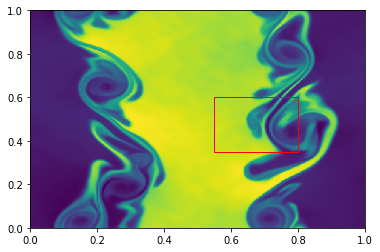

In [4]:
draw_functional(data_path, AreaFunctional())

In [5]:
def get_network_from_functional(data_path, functional, parameters, epochs=500000,max_samples=1024):
    start_reading_samples = time.time()
    samples = get_samples(data_path, functional,max_samples)
    end_reading_samples = time.time()
    print("Reading all samples took {} seconds".format(end_reading_samples-start_reading_samples))
    return get_network(parameters, samples, train_size=train_size, validation_size=validation_size, epochs=epochs,
                      title=functional.title())
def get_network_from_functional_qmc(data_path, functional,epochs=500000, max_samples=1024):
    parameter_path = os.path.join(os.path.dirname(data_path), 'qmc_points.txt')
    parameters = loadtxt(parameter_path)[:max_samples,:]
    
    return get_network_from_functional(data_path, functional, parameters, epochs,max_samples=max_samples)
def get_network(parameters, data, *, train_size, validation_size, epochs=500000, title=''):
    import numpy as np
    
    data = data.reshape(data.shape[0], data.shape[1]*data.shape[2])
    parameters = repeat(parameters, downscale*downscale,0)
    print(data.dtype)
    print(type(data))
    print(data.shape)
    if np.isnan(data).any():
        print("We have a nan!")
    if np.isinf(data).any():
        print("we have an inf!")
    print(data.shape[1])
    input_size = parameters.shape[1]
    model = Sequential([
        Dense(data.shape[1], input_shape=(input_size,)),
        Activation('relu'),
        Dense(data.shape[1]),
        Activation('relu'),
        Dense(2*data.shape[1]),
        Activation('relu'),
        Dense(2*data.shape[1]),
        Activation('relu'),
        Dense(data.shape[1]),
        Activation('relu'),
        Dense(data.shape[1]),
        Activation('relu'),
        Dense(data.shape[1])
    ])
    model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
                  loss='mean_squared_error')
    x_train = parameters[:train_size,:]
  
    y_train=data[:train_size]
    
    
    x_val = parameters[train_size:validation_size+train_size,:]
    y_val=data[train_size:train_size+validation_size,:]
   
    epochs_r=range(1, epochs)
   
    start_training_time = time.time()
  
    hist = model.fit(x_train,
        
                     y_train,
                     batch_size=train_size,
                     #steps_per_epoch=1,
                     epochs=epochs,shuffle=True, 
                     validation_data=(x_val, y_val),
                     #validation_split=validation_size/(validation_size+train_size),
                    #validation_data= ([x_val[k,:] for k in range(x_val.shape[0])], [y_val[k,:] for k in range(x_val.shape[0])]),
                                verbose=0)
    end_training_time = time.time()
    print("Training took {} seconds".format(end_training_time-start_training_time))
    plt.loglog(hist.history['loss'])
    plt.title("Training loss\n%s\n(epochs=%d)" % (title, epochs))
    showAndSave("training_loss")
    
    plt.loglog(hist.history['val_loss'])
    plt.title("Validation loss\n%s\n(epochs=%d)" % (title, epochs))
    showAndSave("training_loss")

   
    print(model.summary())
    print("Number of parameters: %d"% model.count_params())
    
    return  model, data.reshape(data.shape[0], int(sqrt(data.shape[1])), int(sqrt(data.shape[1]))), parameters

In [6]:
def mean_var(d):
    N = d.shape[1]
    mean = zeros((N,N))
    var = zeros((N,N))
    
    print(mean.dtype)
    print(var.dtype)
    print(d.dtype)
    M= d.shape[0]
    for k in range(M):
        mean += d[k,:,:]
        var += d[k,:,:]**2
    mean /= M
    var /= M
    var -= mean**2
    
    return mean, var

def get_network_interpolate_qmc(data_path, functional, epochs=500000,max_samples=1024):
    title='whole field'
    draw_functional(data_path, functional)
    network, data, parameters = get_network_from_functional_qmc(data_path, functional, epochs,max_samples=max_samples)
   
   
    points = [[0.5,0.7], [0.7,0.5],[0.5,0.8],[0.8,0.5]]
    N = data.shape[1]
    
    mean_qmc, var_qmc =mean_var(data)
    mean_few_qmc, var_few_qmc = mean_var(data[:train_size,:,:])
    mean_ml, var_ml = mean_var(network.predict(parameters).reshape(data.shape))
    
    x,y=mgrid[0:1:N*1j,0:1:N*1j]
    
    plt.pcolormesh(x,y,mean_qmc)
    plt.colorbar()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("mean QMC with %d samples" % data.shape[0])
    showAndSave("mean_qmc_%d" % (data.shape[0]))
    
    
    plt.pcolormesh(x,y,mean_few_qmc)
    plt.colorbar()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("mean QMC with %d samples" % train_size)
    showAndSave("mean_qmc_%d" % train_size)
    
    plt.pcolormesh(x,y,mean_ml)
    plt.colorbar()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("mean ML with %d samples" % train_size)
    showAndSave("mean_ml_%d" % train_size)
    
    
    
    plt.pcolormesh(x,y,var_qmc)
    plt.colorbar()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("variance QMC with %d samples" % data.shape[0])
    showAndSave("var_qmc_%d" % (data.shape[0]))
    
    
    plt.pcolormesh(x,y,var_few_qmc)
    plt.colorbar()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("var QMC with %d samples" % train_size)
    showAndSave("var_qmc_%d" % train_size)
    
    plt.pcolormesh(x,y,var_ml)
    plt.colorbar()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("var ML with %d samples" % train_size)
    showAndSave("var_ml_%d" % train_size)
    predicted = network.predict(parameters).reshape(data.shape)
    for p in points:
        
        x = int(p[0]*N)
        y = int(p[1]*N)
        plt.hist(data[:,x,y],bins=40,density=True,label='QMC %d samples' % data.shape[0],alpha=0.5)
        plt.title("Comparison QMC and Machine learning\n%s\nepochs=%d\n at $(%f,%f)$"% (title, epochs,p[0],p[1]))
        plt.hist(predicted[:,x,y],bins=40,density=True,label='ML(%d samples)' % train_size,alpha=0.5)
        plt.legend()
        showAndSave('hist_qmc_ml_whole_%d_%d' %(x,y))
        
        
        plt.title("Comparison QMC with %d and QMC with %d samples\n%s\nat $(%f,%f)$" %(data.shape[0], train_size, title,p[0],p[1]))
        plt.hist(data[:,x,y],bins=40,density=True,label='QMC %d samples' % data.shape[0],alpha=0.5)
        plt.hist(data[:train_size,x,y],bins=40,density=True, alpha=0.5,label='QMC %d samples' % train_size)
        plt.legend()
        showAndSave('hist_qmc_qmc_whole_%d_%d'%(x,y))
        
        
        from sklearn import linear_model
        reg = linear_model.LinearRegression()
        y_train = data[:train_size,x,y]
        coeffs = reg.fit(parameters[:train_size,:], y_train)
        evaluated_lsq = coeffs.predict(parameters)
        plt.title("Comparison QMC with least squares\n%s\n at $(%f,%f)$" % (title,p[0],p[1]))
        plt.hist(data[:,x,y],bins=40,density=True,label='QMC %d samples'%data.shape[0],alpha=0.5)
        plt.hist(evaluated_lsq,bins=40,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
        plt.legend()
        showAndSave('hist_qmc_lsq_whole_%d_%d'%(x,y))
        
    return network, data, parameters

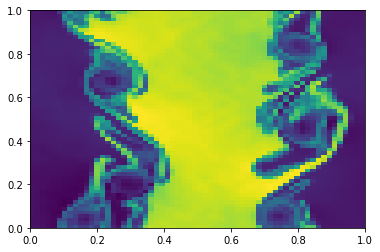

65472
Reading all samples took 29.64084219932556 seconds
float64
<class 'numpy.ndarray'>
(65536, 3969)
3969
Training took 6631.689093112946 seconds
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


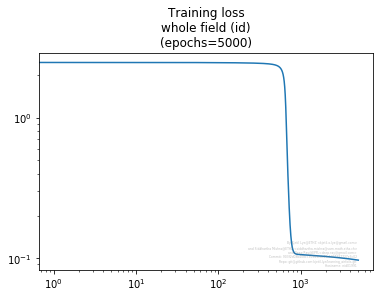

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


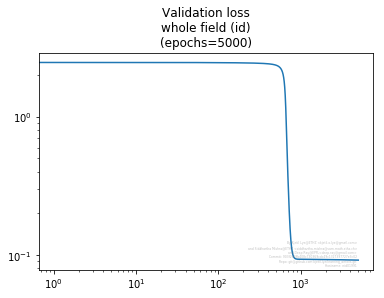

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3969)              162729    
_________________________________________________________________
activation_1 (Activation)    (None, 3969)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3969)              15756930  
_________________________________________________________________
activation_2 (Activation)    (None, 3969)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 7938)              31513860  
_________________________________________________________________
activation_3 (Activation)    (None, 7938)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 7938)              63019782  
__________

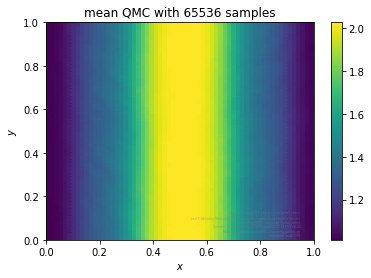

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


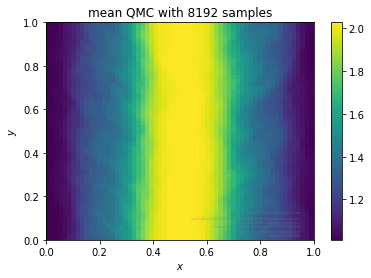

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


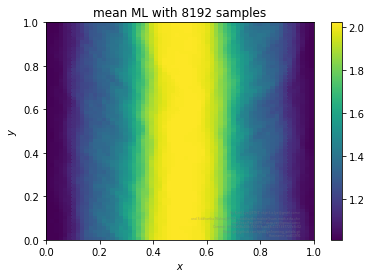

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


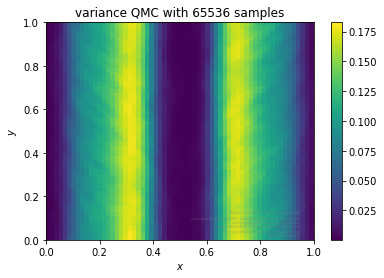

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


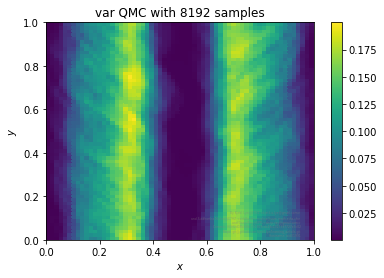

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


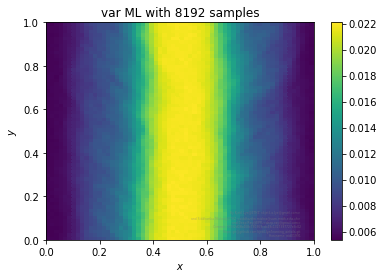

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


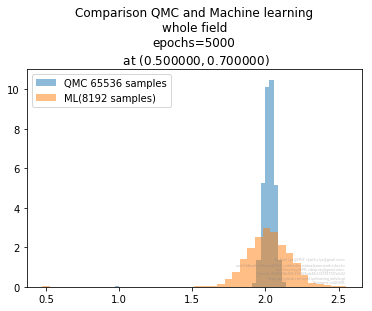

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


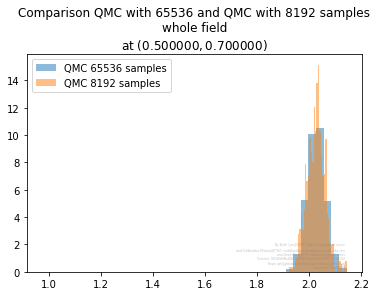

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


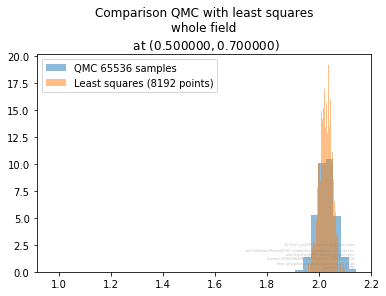

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


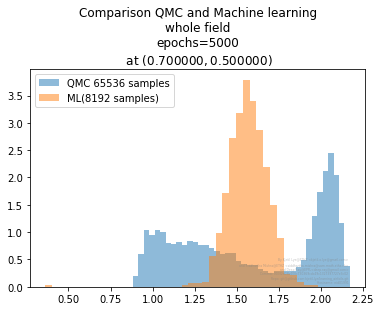

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


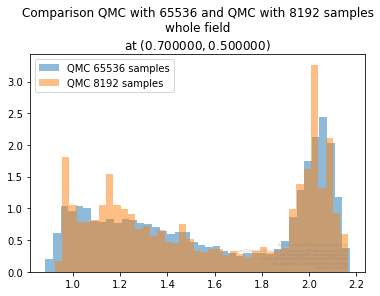

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


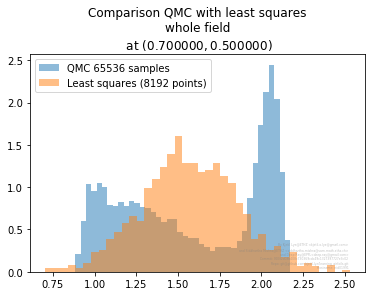

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


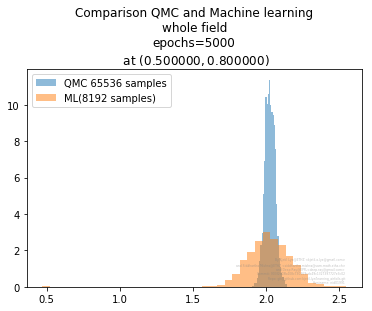

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


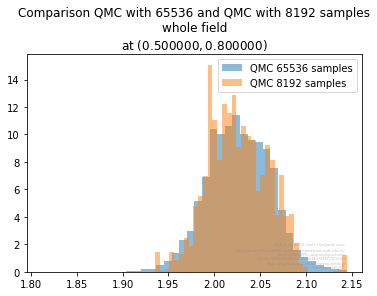

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


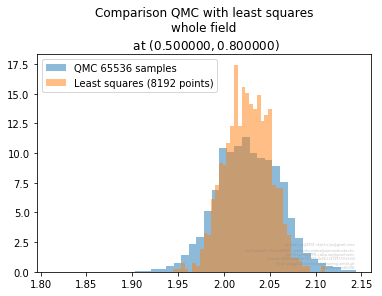

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


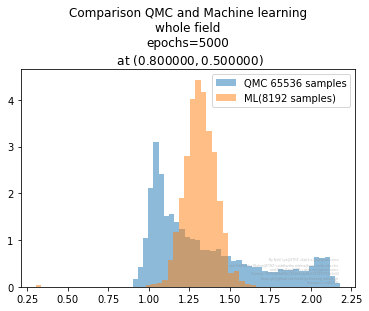

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


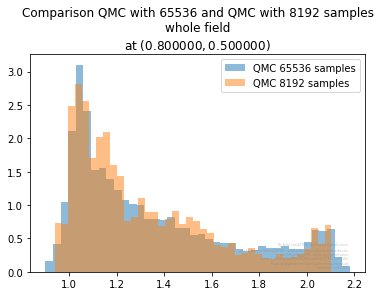

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


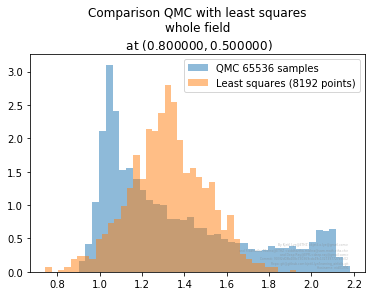

In [7]:
network, data, parameters = get_network_interpolate_qmc(data_path, Identity(), 5000,1024)

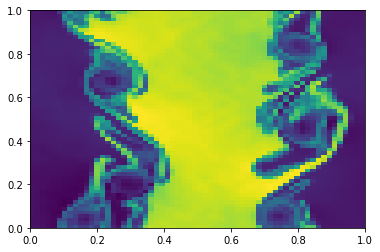

65472
Reading all samples took 26.297902584075928 seconds
float64
<class 'numpy.ndarray'>
(65536, 3969)
3969


In [ ]:
network, data, parameters = get_network_interpolate_qmc(data_path, Identity(), 50000,1024)

In [ ]:
network, data, parameters = get_network_interpolate_qmc(data_path, Identity(), 500000,1024)

In [ ]:
network, data, parameters = get_network_interpolate_qmc(data_path, Identity(), 2000000,1024)